<h1><font size="6">Diabetes Classification</font></h1>

In this notebook, uses two retina datasets to challenge the diabetes classification.

## Contents
* [Import libraries](#import)
* [Set configurations and read metadata](#set)
* [Process Cataract dataset](#process1)
* [Process Ocular disease recognition dataset](#process2)
* [Create datasets](#create)
* [Model1 - Custom CNN](#build1)
* [Model2 - EfficientNetB0](#build2)
* [Model3 - EfficientNetB4](#build3)
* [Model5 - InceptionV3](#build5)
* [Model6 - EffUNetB0](#build6)

## Import libraries <a name="import"> </a>

In [1]:
!pip install -q efficientnet >> /dev/null

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import os, glob, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from scipy.signal import gaussian, convolve2d
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import get_custom_objects
import efficientnet.tfkeras as efn
from tqdm import tqdm

## Set configurations and read metadata <a name="set"> </a>

In [3]:
SEED = 42
EPOCHS = 100
BATCH_SIZE = 32
IMG_HEIGHT = 192
IMG_WIDTH = 256

# cataract dataset
IMG_ROOT = '/kaggle/input/cataractdataset/dataset/'
IMG_DIR = [IMG_ROOT+'1_normal', 
           IMG_ROOT+'2_cataract', 
           IMG_ROOT+'2_glaucoma', 
           IMG_ROOT+'3_retina_disease']

# ocular-disease-recognition dataset
OCU_IMG_ROOT = '/kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images/'
ocu_df = pd.read_excel('/kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/data.xlsx')

In [4]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

## Process Cataract dataset <a name="process1"> </a>

In [5]:
# cat_df = pd.DataFrame(0, 
#                   columns=['paths', 
#                            'diabetes'],
#                   index=range(601))

# filepaths = glob.glob(IMG_ROOT + '*/*')


# for i, filepath in enumerate(filepaths):
#     filepath = os.path.split(filepath)
#     cat_df.iloc[i, 0] = filepath[0] + '/' + filepath[1]
    
#     if filepath[0] == IMG_DIR[0]:    # normal
#         cat_df.iloc[i, 1] = 0
#     elif filepath[0] == IMG_DIR[1]:  # cataract
#         cat_df.iloc[i, 1] = 1
#     elif filepath[0] == IMG_DIR[2]:  # glaucoma
#         cat_df.iloc[i, 1] = 2
#     elif filepath[0] == IMG_DIR[3]:  # retine_disease
#         cat_df.iloc[i, 1] = 3
        
# # only sample normal and rd        
# cat_df = cat_df[cat_df['diabetes'].isin([0, 3])]
# # convert the '3' of rd to '1'
# cat_df['diabetes'] = cat_df['diabetes'].replace(3, 1)
# cat_df

In [6]:
# print('Number of normal and diabetes images')
# print(cat_df['diabetes'].value_counts())

## Process Ocular disease recognition dataset <a name="process2"> </a>

In [7]:
ocu_df

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,4686,63,Male,4686_left.jpg,4686_right.jpg,severe nonproliferative retinopathy,proliferative diabetic retinopathy,0,1,0,0,0,0,0,0
3496,4688,42,Male,4688_left.jpg,4688_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0
3497,4689,54,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0
3498,4690,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0


In [8]:
def has_diabetes_mentioned(text):
    if 'retinopathy' in text:
            return 0
    else:
        return 1
    
ocu_df['left_eye_diabetes'] = ocu_df['Left-Diagnostic Keywords'].apply(lambda x: has_diabetes_mentioned(x))
ocu_df['right_eye_diabetes'] = ocu_df['Right-Diagnostic Keywords'].apply(lambda x: has_diabetes_mentioned(x))

In [9]:
le_df = ocu_df.loc[:, ['Left-Fundus', 'left_eye_diabetes']].rename(columns={'left_eye_diabetes':'diabetes'})
le_df['paths'] = OCU_IMG_ROOT + le_df['Left-Fundus']
le_df = le_df.drop('Left-Fundus', axis=1)


re_df = ocu_df.loc[:, ['Right-Fundus', 'right_eye_diabetes']].rename(columns={'right_eye_diabetes':'diabetes'})
re_df['paths'] = OCU_IMG_ROOT + re_df['Right-Fundus']
re_df = re_df.drop('Right-Fundus', axis=1)

In [10]:
le_df.head()

,diabetes,paths
0,1,/kaggle/input/ocular-disease-recognition-odir5...
1,1,/kaggle/input/ocular-disease-recognition-odir5...
2,0,/kaggle/input/ocular-disease-recognition-odir5...
3,1,/kaggle/input/ocular-disease-recognition-odir5...
4,1,/kaggle/input/ocular-disease-recognition-odir5...


In [11]:
re_df.head()

,diabetes,paths
0,1,/kaggle/input/ocular-disease-recognition-odir5...
1,1,/kaggle/input/ocular-disease-recognition-odir5...
2,0,/kaggle/input/ocular-disease-recognition-odir5...
3,1,/kaggle/input/ocular-disease-recognition-odir5...
4,0,/kaggle/input/ocular-disease-recognition-odir5...


In [12]:
print('Number of left eye diabetes images')
print(le_df['diabetes'].value_counts())
print('\nNumber of right eye diabetes images')
print(re_df['diabetes'].value_counts())

Number of left eye diabetes images
1    2541
0     959
Name: diabetes, dtype: int64

Number of right eye diabetes images
1    2508
0     992
Name: diabetes, dtype: int64


There is a large bias in the dataset. So make it even.

In [13]:
def downsample(df):
    min_class_count = df['diabetes'].value_counts().min()
    df = pd.concat([
        df[df['diabetes']==0].sample(min_class_count,random_state=SEED), #normal
        df[df['diabetes']==1].sample(min_class_count,random_state=SEED), #diabetes
    ])
    return df


le_df = downsample(le_df)
re_df = downsample(re_df)

print('Number of left eye images')
print(le_df['diabetes'].value_counts())
print('\nNumber of right eye images')
print(re_df['diabetes'].value_counts())

Number of left eye images
1    959
0    959
Name: diabetes, dtype: int64

Number of right eye images
1    992
0    992
Name: diabetes, dtype: int64


In [14]:
ocu_df = pd.concat([le_df, re_df])
ocu_df.head()

,diabetes,paths
3357,0,/kaggle/input/ocular-disease-recognition-odir5...
2895,0,/kaggle/input/ocular-disease-recognition-odir5...
1129,0,/kaggle/input/ocular-disease-recognition-odir5...
3423,0,/kaggle/input/ocular-disease-recognition-odir5...
3379,0,/kaggle/input/ocular-disease-recognition-odir5...


In [15]:
ocu_df

,diabetes,paths
3357,0,/kaggle/input/ocular-disease-recognition-odir5...
2895,0,/kaggle/input/ocular-disease-recognition-odir5...
1129,0,/kaggle/input/ocular-disease-recognition-odir5...
3423,0,/kaggle/input/ocular-disease-recognition-odir5...
3379,0,/kaggle/input/ocular-disease-recognition-odir5...
...,...,...
2852,1,/kaggle/input/ocular-disease-recognition-odir5...
1385,1,/kaggle/input/ocular-disease-recognition-odir5...
1097,1,/kaggle/input/ocular-disease-recognition-odir5...
2646,1,/kaggle/input/ocular-disease-recognition-odir5...


## Create datasets <a name="create"> </a>
Combine the two metadata and use them to load the image data and create datasets.

In [16]:
# df = pd.concat([cat_df, ocu_df], ignore_index=True).sample(1000, random_state=SEED)
# training only on labeled retina_disease
# downsampled_cat_df = downsample(cat_df)
# df = downsampled_cat_df.sample(1000)

In [17]:
df = ocu_df
df['diabetes'].value_counts()

1    1951
0    1951
Name: diabetes, dtype: int64

In [18]:
train_df, test_df = train_test_split(df, 
                                     test_size=0.2, 
                                     random_state=SEED, 
                                     stratify=df['diabetes'])

train_df, val_df = train_test_split(train_df,
                                    test_size=0.15,
                                    random_state=SEED,
                                    stratify=train_df['diabetes'])

In [19]:
# wiener filter
def wiener_filter(img, kernel, K):
    kernel /= np.sum(kernel)
    dummy = np.copy(img)
    dummy = np.fft.fft2(dummy)
    kernel = np.fft.fft2(kernel, s = img.shape)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    dummy = dummy * kernel
    dummy = np.abs(np.fft.ifft2(dummy))
    return dummy.astype('uint8')

def gaussian_kernel(kernel_size = 3):
    h = gaussian(kernel_size, kernel_size / 3).reshape(kernel_size, 1)
    h = np.dot(h, h.transpose())
    h /= np.sum(h)
    return h


def wiener(image):
    green=image[:, :, 1]
    wiener = wiener_filter(green, gaussian_kernel(3), 10)
    green = cv2.addWeighted(green, 1.5, wiener, -0.5, 0)
    img=cv2.merge((green,green,green))
    return img

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img
    
def image_preprocessing(image, img_width, img_height):
    image = crop_image_from_gray(image)
    kernel = gaussian_kernel(kernel_size=3)
    image = wiener(image)

    # Apply CLAHE on green channel
    green=image[:, :, 1]
    clipLimit = 2.0
    tileGridSize = (8,8)
    clahe=cv2.createCLAHE(clipLimit = clipLimit, tileGridSize = tileGridSize)
    cla=clahe.apply(green.astype('uint8'))
    image=cv2.merge((cla,cla,cla))
    return image.astype('float64')

In [20]:
def create_datasets(df, img_width, img_height):
    imgs = []
    for path in tqdm(df['paths']):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         img = image_preprocessing(img, img_width, img_height)
        img = cv2.resize(img, (img_width, img_height))
        img = img / 255.
        imgs.append(img)
        
    imgs = np.array(imgs, dtype='float32')
    df = pd.get_dummies(df['diabetes'])
    return imgs, df


train_imgs, train_df = create_datasets(train_df, IMG_WIDTH, IMG_HEIGHT)
val_imgs, val_df = create_datasets(val_df, IMG_WIDTH, IMG_HEIGHT)
test_imgs, test_df = create_datasets(test_df, IMG_WIDTH, IMG_HEIGHT)

100%|██████████| 781/781 [00:45<00:00, 17.33it/s]


In [21]:
len(train_imgs)

2652

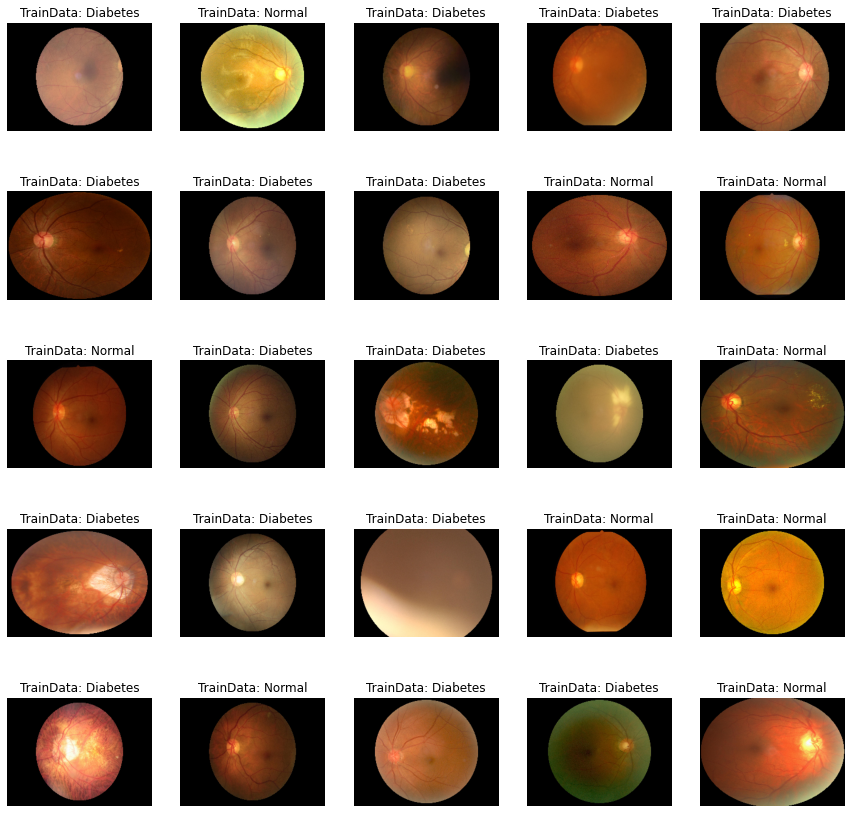

In [22]:
# plot the first 25 sheets of image data for training

f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(train_df[0][:25])
for i, img in enumerate(train_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TrainData: Normal')
    else:
        ax[i//5, i%5].set_title('TrainData: Diabetes')
plt.show()

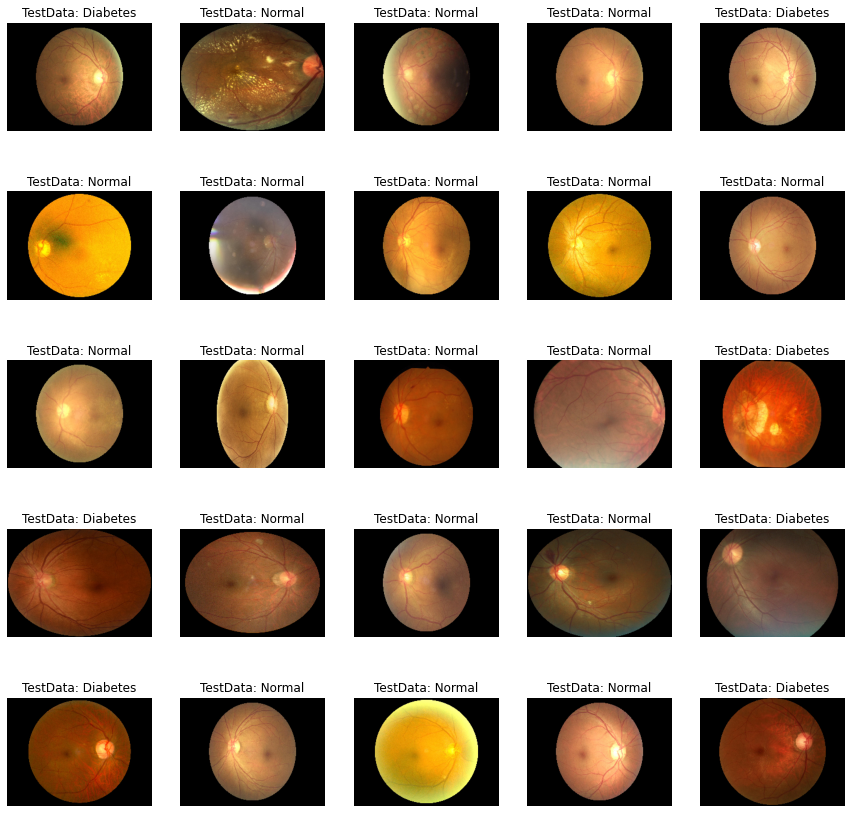

In [23]:
# plot the first 25 sheets of image data for Test
f, ax = plt.subplots(5, 5, figsize=(15,15))
norm_list = list(test_df[0][:25])
for i, img in enumerate(test_imgs[:25]):
    ax[i//5, i%5].imshow(img)
    ax[i//5, i%5].axis('off')
    if norm_list[i] == 1:
        ax[i//5, i%5].set_title('TestData: Normal')
    else:
        ax[i//5, i%5].set_title('TestData: Diabetes')
plt.show()

## Model1 - Custom CNN <a name="build1"> </a>

In [24]:
# class Mish(tf.keras.layers.Layer):
#     def __init__(self, **kwargs):
#         super(Mish, self).__init__(**kwargs)
#         self.supports_masking = True

#     def call(self, inputs):
#         return inputs * K.tanh(K.softplus(inputs))

#     def get_config(self):
#         base_config = super(Mish, self).get_config()
#         return dict(list(base_config.items()) + list(config.items()))

#     def compute_output_shape(self, input_shape):
#         return input_shape
    
def mish(x):
    return tf.keras.layers.Lambda(lambda x: x*K.tanh(K.softplus(x)))(x)
 
get_custom_objects().update({'mish': Activation(mish)})

In [25]:
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

model = Sequential()
model.add(Conv2D(16, kernel_size=3, padding='same', 
                 input_shape=input_shape, activation='mish'))
model.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
model.add(BatchNormalization())
model.add(MaxPool2D(3))
model.add(Dropout(0.3))
model.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
model.add(Conv2D(16, kernel_size=3, padding='same', activation='mish'))
model.add(BatchNormalization())
model.add(MaxPool2D(3))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 192, 256, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 192, 256, 16)      2320      
_________________________________________________________________
batch_normalization (BatchNo (None, 192, 256, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 85, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 85, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 85, 16)        2320      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 85, 16)        2

Use some image data augmentation to generate randomly augmented image data from the ImageDataGenerator Object.

In [26]:
generator = ImageDataGenerator(horizontal_flip=True, 
                               height_shift_range=0.1,
                               fill_mode='reflect') 

es_callback = tf.keras.callbacks.EarlyStopping(patience=20, 
                                               verbose=1, 
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

Epoch 1/100
83/83 [==============================] - 25s 297ms/step - loss: 1.3102 - accuracy: 0.5143 - val_loss: 0.6910 - val_accuracy: 0.5181
Epoch 2/100
83/83 [==============================] - 25s 298ms/step - loss: 1.0702 - accuracy: 0.5366 - val_loss: 0.7045 - val_accuracy: 0.5117
Epoch 3/100
83/83 [==============================] - 25s 295ms/step - loss: 1.0272 - accuracy: 0.5343 - val_loss: 0.9309 - val_accuracy: 0.4989
Epoch 4/100
83/83 [==============================] - 24s 294ms/step - loss: 1.0998 - accuracy: 0.5724 - val_loss: 0.7351 - val_accuracy: 0.5394
Epoch 5/100
83/83 [==============================] - 25s 297ms/step - loss: 0.9886 - accuracy: 0.5618 - val_loss: 0.7040 - val_accuracy: 0.5821
Epoch 6/100
83/83 [==============================] - 25s 300ms/step - loss: 0.9892 - accuracy: 0.5509 - val_loss: 0.7583 - val_accuracy: 0.5970
Epoch 7/100
83/83 [==============================] - 24s 295ms/step - loss: 0.9932 - accuracy: 0.5411 - val_loss: 0.8135 - val_accuracy:

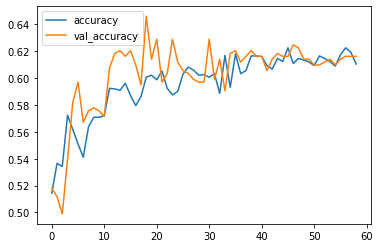

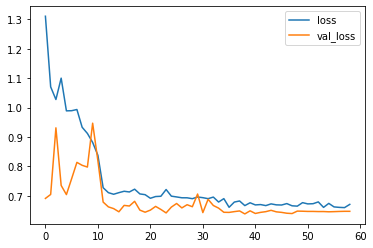

In [27]:
history = model.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
#                     steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))

pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

In [28]:
model.save("Custom_CNN.h5")
model.evaluate(test_imgs, test_df) 

25/25 [==============================] - 0s 17ms/step - loss: 0.6726 - accuracy: 0.5992


[0.6725682020187378, 0.5992317795753479]

In [29]:
test_labels = test_df.idxmax(axis=1)
pred_labels1 = np.argmax(model.predict(test_imgs), axis=1)

In [30]:
def plot_cm(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print(classification_report(y_true, y_pred, target_names=['No Diabetes', 'Diabetes']))
    plt.figure(figsize=(5, 4))
    ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

              precision    recall  f1-score   support

 No Diabetes       0.58      0.70      0.64       391
    Diabetes       0.62      0.50      0.55       390

    accuracy                           0.60       781
   macro avg       0.60      0.60      0.59       781
weighted avg       0.60      0.60      0.60       781



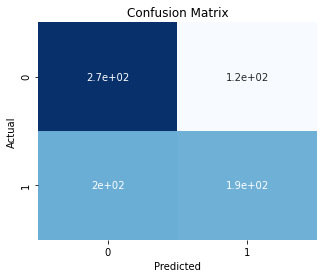

In [31]:
plot_cm(test_labels, pred_labels1)

## Model2 - EfficientNetB0 <a name="build2"> </a>

In [32]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    efnet = efn.EfficientNetB0(
        input_shape=(img_height,img_width,n), 
        weights='imagenet', 
        include_top=False
    )
    x = efnet(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Nadam(learning_rate=0.00003, beta_1=0.5, beta_2=0.555, epsilon=1e-6)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

model2 = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model2.summary()

16809984/16804768 [==============================] - 0s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 192, 256, 3)]     0         
_________________________________________________________________
efficientnet-b0 (Functional) (None, 6, 8, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2562      
Total params: 4,052,126
Trainable params: 4,010,110
Non-trainable params: 42,016
_________________________________________________________________


In [33]:
generator = ImageDataGenerator(horizontal_flip=True, 
                               height_shift_range=0.1,
                               fill_mode='reflect') 

es_callback = tf.keras.callbacks.EarlyStopping(patience=11, 
                                               verbose=1, 
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

Epoch 1/100
83/82 [==============================] - 28s 336ms/step - loss: 0.6907 - accuracy: 0.5618 - val_loss: 0.7238 - val_accuracy: 0.5330
Epoch 2/100
83/82 [==============================] - 26s 315ms/step - loss: 0.6453 - accuracy: 0.6244 - val_loss: 0.7189 - val_accuracy: 0.5437
Epoch 3/100
83/82 [==============================] - 26s 317ms/step - loss: 0.6194 - accuracy: 0.6561 - val_loss: 0.6817 - val_accuracy: 0.5970
Epoch 4/100
83/82 [==============================] - 26s 313ms/step - loss: 0.5888 - accuracy: 0.6942 - val_loss: 0.6447 - val_accuracy: 0.6311
Epoch 5/100
83/82 [==============================] - 26s 311ms/step - loss: 0.5759 - accuracy: 0.7044 - val_loss: 0.6272 - val_accuracy: 0.6567
Epoch 6/100
83/82 [==============================] - 26s 318ms/step - loss: 0.5487 - accuracy: 0.7262 - val_loss: 0.6247 - val_accuracy: 0.6503
Epoch 7/100
83/82 [==============================] - 27s 319ms/step - loss: 0.5311 - accuracy: 0.7406 - val_loss: 0.6232 - val_accuracy:

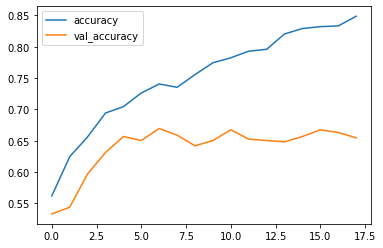

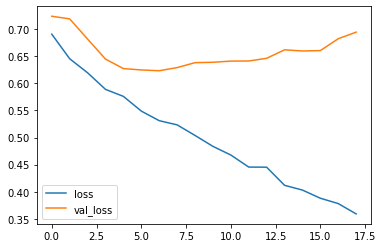

In [34]:
history2 = model2.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history2.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history2.history)[['loss', 'val_loss']].plot()
plt.show()

In [35]:
model2.evaluate(test_imgs, test_df) 

25/25 [==============================] - 1s 40ms/step - loss: 0.6424 - accuracy: 0.6504


[0.6423575282096863, 0.6504481434822083]

              precision    recall  f1-score   support

 No Diabetes       0.65      0.64      0.65       391
    Diabetes       0.65      0.66      0.65       390

    accuracy                           0.65       781
   macro avg       0.65      0.65      0.65       781
weighted avg       0.65      0.65      0.65       781



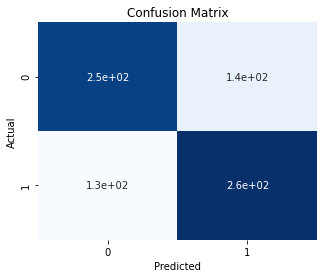

In [36]:
pred_labels2 = np.argmax(model2.predict(test_imgs), axis=1)
plot_cm(test_labels, pred_labels2)

In [37]:
model2.save("effb0.h5")

## Model3 - EfficientNetB4 <a name="build3"> </a>

In [38]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    efnet = efn.EfficientNetB4(
        input_shape=(img_height,img_width,n), 
        weights='imagenet', 
        include_top=False
    )
    x = efnet(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Nadam(learning_rate=0.00003, beta_1=0.5, beta_2=0.555, epsilon=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

model3 = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model3.summary()

71892992/71892840 [==============================] - 1s 0us/step
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 192, 256, 3)]     0         
_________________________________________________________________
efficientnet-b4 (Functional) (None, 6, 8, 1792)        17673816  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1792)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 3586      
Total params: 17,677,402
Trainable params: 17,552,202
Non-trainable params: 125,200
_________________________________________________________________


Epoch 1/100
83/82 [==============================] - 46s 555ms/step - loss: 0.6905 - accuracy: 0.5445 - val_loss: 0.6904 - val_accuracy: 0.5522
Epoch 2/100
83/82 [==============================] - 42s 511ms/step - loss: 0.6486 - accuracy: 0.6199 - val_loss: 0.6731 - val_accuracy: 0.5949
Epoch 3/100
83/82 [==============================] - 42s 511ms/step - loss: 0.6130 - accuracy: 0.6712 - val_loss: 0.6489 - val_accuracy: 0.6311
Epoch 4/100
83/82 [==============================] - 43s 518ms/step - loss: 0.5901 - accuracy: 0.6829 - val_loss: 0.6374 - val_accuracy: 0.6461
Epoch 5/100
83/82 [==============================] - 42s 512ms/step - loss: 0.5660 - accuracy: 0.7115 - val_loss: 0.6454 - val_accuracy: 0.6525
Epoch 6/100
83/82 [==============================] - 43s 513ms/step - loss: 0.5488 - accuracy: 0.7255 - val_loss: 0.6270 - val_accuracy: 0.6439
Epoch 7/100
83/82 [==============================] - 42s 509ms/step - loss: 0.5307 - accuracy: 0.7304 - val_loss: 0.6287 - val_accuracy:

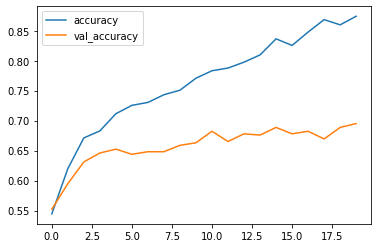

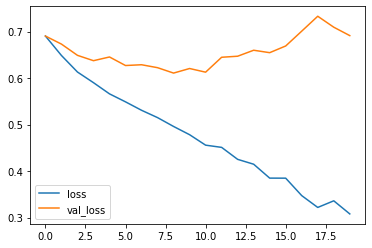

In [39]:
history3 = model3.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history3.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history3.history)[['loss', 'val_loss']].plot()
plt.show()

In [40]:
model3.evaluate(test_imgs, test_df)

25/25 [==============================] - 2s 91ms/step - loss: 0.6808 - accuracy: 0.6709


[0.6807913780212402, 0.6709346771240234]

              precision    recall  f1-score   support

 No Diabetes       0.67      0.66      0.67       391
    Diabetes       0.67      0.68      0.67       390

    accuracy                           0.67       781
   macro avg       0.67      0.67      0.67       781
weighted avg       0.67      0.67      0.67       781



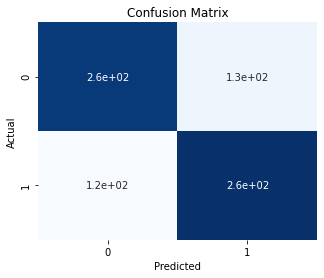

In [41]:
pred_labels3 = np.argmax(model3.predict(test_imgs), axis=1)
plot_cm(test_labels, pred_labels3)

In [42]:
model3.save("effb4.h5")

## Model5 - InceptionV3 <a name="build5"> </a>

In [43]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    resnet = tf.keras.applications.InceptionV3(
        input_shape=(img_height,img_width,n), 
        weights='imagenet', 
        include_top=False
    )
    x = resnet(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(2, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Nadam(learning_rate=0.00003, beta_1=0.7, beta_2=0.777, epsilon=1e-6)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
    return model

model5 = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model5.summary()

87916544/87910968 [==============================] - 3s 0us/step
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 192, 256, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 4, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 21,772,450
Non-trainable params: 34,432
_________________________________________________________________


Epoch 1/100
83/82 [==============================] - 29s 345ms/step - loss: 0.6902 - accuracy: 0.5958 - val_loss: 0.7155 - val_accuracy: 0.5203
Epoch 2/100
83/82 [==============================] - 26s 319ms/step - loss: 0.6001 - accuracy: 0.6738 - val_loss: 0.7263 - val_accuracy: 0.6077
Epoch 3/100
83/82 [==============================] - 26s 312ms/step - loss: 0.5347 - accuracy: 0.7319 - val_loss: 0.7298 - val_accuracy: 0.6461
Epoch 4/100
83/82 [==============================] - 26s 314ms/step - loss: 0.4783 - accuracy: 0.7722 - val_loss: 0.7121 - val_accuracy: 0.6652
Epoch 5/100
83/82 [==============================] - 26s 317ms/step - loss: 0.4131 - accuracy: 0.8220 - val_loss: 0.8234 - val_accuracy: 0.6226
Epoch 6/100
83/82 [==============================] - 26s 313ms/step - loss: 0.3476 - accuracy: 0.8511 - val_loss: 0.8686 - val_accuracy: 0.6247
Epoch 7/100
83/82 [==============================] - 26s 318ms/step - loss: 0.2965 - accuracy: 0.8771 - val_loss: 0.9117 - val_accuracy:

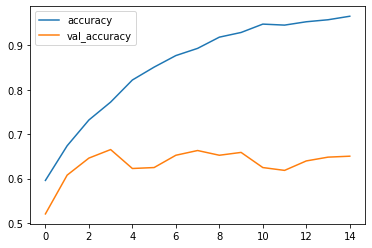

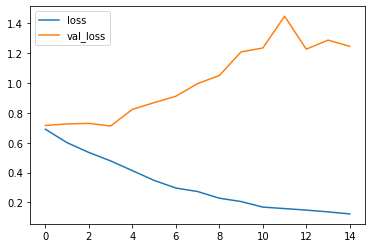

In [44]:
history5 = model5.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))

pd.DataFrame(history5.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history5.history)[['loss', 'val_loss']].plot()
plt.show()

In [45]:
model5.evaluate(test_imgs, test_df)

25/25 [==============================] - 1s 55ms/step - loss: 0.7649 - accuracy: 0.6069


[0.7648509740829468, 0.606914222240448]

In [46]:
model5.save("inceptionv3.h5")

              precision    recall  f1-score   support

 No Diabetes       0.61      0.61      0.61       391
    Diabetes       0.61      0.60      0.60       390

    accuracy                           0.61       781
   macro avg       0.61      0.61      0.61       781
weighted avg       0.61      0.61      0.61       781



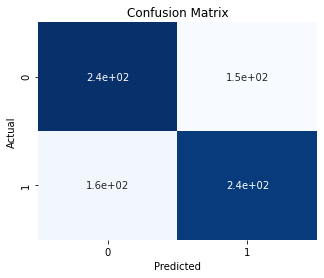

In [47]:
pred_labels5 = np.argmax(model5.predict(test_imgs), axis=1)
plot_cm(test_labels, pred_labels5)

## Model6 - EffUnet <a name="build6"> </a>

In [48]:
# Convolution, Batch Normalization, Activation then Residual Connection
def CBAR_block(input_layer, num_filters):
    x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=3, padding='same')(input_layer)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    xd = tf.keras.layers.Conv2D(filters=num_filters, kernel_size=1)(input_layer)
    x = tf.keras.layers.Add()([x, xd])

    return x


def get_efficientnet(name='B0', input_shape=(IMG_HEIGHT,IMG_WIDTH, 3)):
    return efn.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_tensor=None,
        input_shape=input_shape,
        pooling=None,
    )

def buildEffUnetb0(input_shape = (IMG_HEIGHT,IMG_WIDTH,3), num_classes=5):
    encoder_model = get_efficientnet(name='B0', input_shape=input_shape)
    new_input = encoder_model.input
    # encoder output, we won't use the top_conv (which has 1280 filters)
    # let's just use 7a bn, which is 7 x 7 x 320
    encoder_output = encoder_model.get_layer(name='block7a_project_bn').output

    # filter number for the bottleneck
    fn_bottle_neck = encoder_output.shape[-1]
    bottleneck = CBAR_block(encoder_output, int(fn_bottle_neck))
    # Decoder block 1
    c1 = encoder_model.get_layer(name='block5c_drop').output
    fn_1 = c1.shape[-1]
    upsampling1 = tf.keras.layers.UpSampling2D()(bottleneck)
    concatenation1 = tf.keras.layers.concatenate(
            [upsampling1, c1], axis=3)
    decoder1 = CBAR_block(concatenation1, int(fn_1))

    # Decoder block 2
    c2 = encoder_model.get_layer(name='block3b_drop').output
    fn_2 = c2.shape[-1]
    upsampling2 = tf.keras.layers.UpSampling2D()(decoder1)
    concatenation2 = tf.keras.layers.concatenate(
            [upsampling2, c2], axis=3)
    decoder2 = CBAR_block(concatenation2, int(fn_2))

    # Decoder block 3
    c3 = encoder_model.get_layer(name='block2b_drop').output
    fn_3 = c3.shape[-1]
    upsampling3 = tf.keras.layers.UpSampling2D()(decoder2)
    concatenation3 = tf.keras.layers.concatenate(
            [upsampling3, c3], axis=3)
    decoder3 = CBAR_block(concatenation3, int(fn_3))

    # Decoder block 4
    # 1a does not have dropout
    c4 = encoder_model.get_layer(name='block1a_project_bn').output
    fn_4 = c4.shape[-1]
    upsampling4 = tf.keras.layers.UpSampling2D()(decoder3)
    concatenation4 = tf.keras.layers.concatenate(
            [upsampling4, c4], axis=3)
    decoder4 = CBAR_block(concatenation4, int(fn_4))

    # Decoder block 5
    # the only layer with original shape is input...
    fn_5 = fn_4 # let's resuse this filter number for now
    upsampling5 = tf.keras.layers.UpSampling2D()(decoder4)
    concatenation5 = tf.keras.layers.concatenate(
            [upsampling5, new_input], axis=3)
    decoder5 = CBAR_block(concatenation5, int(fn_5))

    # Now we can add in the output portion
    final_activation = 'softmax'
    p = tf.keras.layers.GlobalAveragePooling2D()(decoder5)
    d11 = tf.keras.layers.Dense(units = 256, activation = 'relu',kernel_regularizer= tf.keras.regularizers.l2(0.0001))(p)
    d11_drop = tf.keras.layers.Dropout(0.2)(d11)
    final_output = tf.keras.layers.Dense(units = 2, activation = 'softmax')(d11_drop)
        
    efficient_unet = tf.keras.Model(inputs=new_input, outputs=final_output)
    nadam = tf.keras.optimizers.Nadam(learning_rate=0.00003, beta_1=0.5, beta_2=0.555, epsilon=1e-7)
    efficient_unet.compile(optimizer=nadam, loss='categorical_crossentropy', metrics = ['accuracy'])
    print(efficient_unet.summary())
    
    return efficient_unet

In [49]:
model6 = buildEffUnetb0()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 96, 128, 32)  864         input_7[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 96, 128, 32)  128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 96, 128, 32)  0           stem_bn[0][0]                    
_______________________________________________________________________________________

In [50]:
generator = ImageDataGenerator(horizontal_flip=True, 
                               height_shift_range=0.1,
                               fill_mode='reflect') 

es_callback = tf.keras.callbacks.EarlyStopping(patience=20, 
                                               verbose=1, 
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2, verbose=1)

Epoch 1/100
83/82 [==============================] - 30s 360ms/step - loss: 0.7208 - accuracy: 0.5637 - val_loss: 0.8700 - val_accuracy: 0.5075
Epoch 2/100
83/82 [==============================] - 27s 326ms/step - loss: 0.6632 - accuracy: 0.6192 - val_loss: 0.9558 - val_accuracy: 0.5117
Epoch 3/100
83/82 [==============================] - ETA: 0s - loss: 0.6439 - accuracy: 0.6474
Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.9999999242136257e-06.
83/82 [==============================] - 27s 328ms/step - loss: 0.6439 - accuracy: 0.6474 - val_loss: 1.0238 - val_accuracy: 0.5075
Epoch 4/100
83/82 [==============================] - 26s 317ms/step - loss: 0.6069 - accuracy: 0.6716 - val_loss: 0.7760 - val_accuracy: 0.5821
Epoch 5/100
83/82 [==============================] - 27s 322ms/step - loss: 0.6098 - accuracy: 0.6738 - val_loss: 0.6808 - val_accuracy: 0.6269
Epoch 6/100
83/82 [==============================] - 28s 336ms/step - loss: 0.5940 - accuracy: 0.6859 - val_loss: 0.

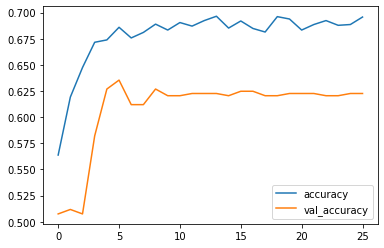

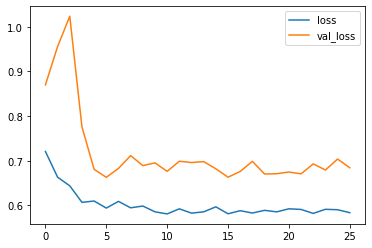

In [51]:
history6 = model6.fit(generator.flow(train_imgs, 
                                   train_df,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_imgs)/BATCH_SIZE,
                    callbacks=[es_callback, reduce_lr],
                    validation_data=(val_imgs, val_df))

pd.DataFrame(history6.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history6.history)[['loss', 'val_loss']].plot()
plt.show()

In [52]:
model6.evaluate(test_imgs, test_df) 
model6.save("effunetb0.h5")

25/25 [==============================] - 1s 59ms/step - loss: 0.6605 - accuracy: 0.6428


              precision    recall  f1-score   support

 No Diabetes       0.68      0.55      0.61       391
    Diabetes       0.62      0.74      0.67       390

    accuracy                           0.64       781
   macro avg       0.65      0.64      0.64       781
weighted avg       0.65      0.64      0.64       781



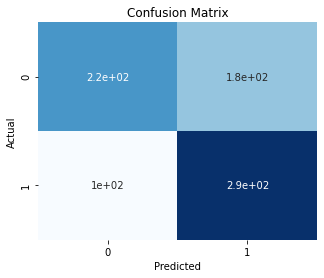

In [53]:
pred_labels6 = np.argmax(model6.predict(test_imgs), axis=1)
plot_cm(test_labels, pred_labels6)